In [ ]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os
 
# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "dim_reduction"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 불필요한 경고를 무시합니다 (사이파이 이슈 #5998 참조)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

* 차원의 저주(curse of dimensionality)
<br> : 많은 특성은 훈련을 느리게 할 뿐만 아니라 좋은 솔루션을 찾기 어렵게 만든다.

<br>

* 차원 축소
    1. 일부 정보가 유실 => 훈련 속도 ↑, 시스템의 성능 ↓, 파이프라인 복잡도↑
<br> 그러므로, 차원 축소를 고려하기 전에 훈련이 너무 느린지 먼저 원본 데이터로 시스템 훈련 필요
    2. 데이터 시각화(data visualization)에 유용

#8.1 차원의 저주

고차원의 데이터 셋은 대부분의 훈련 데이터가 서로 멀리 떨어져 있다. <br> (즉, 새로운 샘플도 훈련 샘플과 멀리 떨어져 있을 가능성이 높다.)
<br> => 훈련 세트의 차원이 클수록 과대적합 위험이 커진다.
<br> 
<br> 이를 해결하기 위해서는 훈련 세트의 크기를 훈련 샘플의 밀도가 충분히 높아질 때까지 키워야하는데, 이는 현실적으로 불가능하다.

#8.2 차원 축소를 위한 접근 방법

##8.2.1 투영(projection)

많은 특성은 거의 변화가 없는 반면, 다른 특성들은 서로 강하게 연관되어 있다.
<br> 결과적으로, **모든 훈련 샘플이 고차원 공간 안의 저차원 부분 공간(subspace)에 놓여 있다**고 할 수 있다.

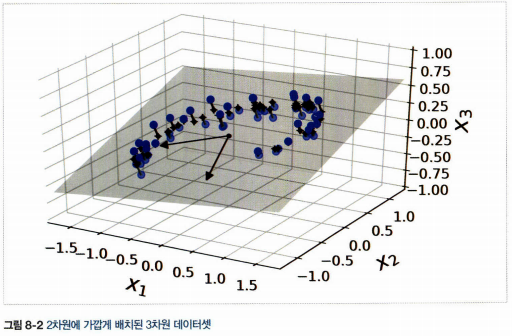

모든 훈련 샘플을 저차원 부분 공간에 **수직으로 투영**(즉, 샘플과 평면 사이의 가장 짧은 직선을 따라) 하면 차원이 축소된 데이터셋을 얻을 수 있다.

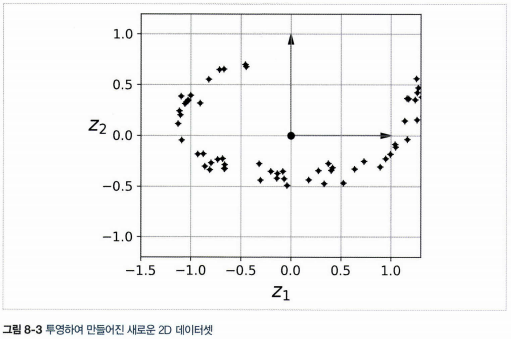

하지만 많은 경우에 아래의 스위스롤 데이터셋처럼 부분 공간이 뒤틀리거나 휘어 있기도 하기 때문에 항상 투영이 좋은 방법은 아니다.

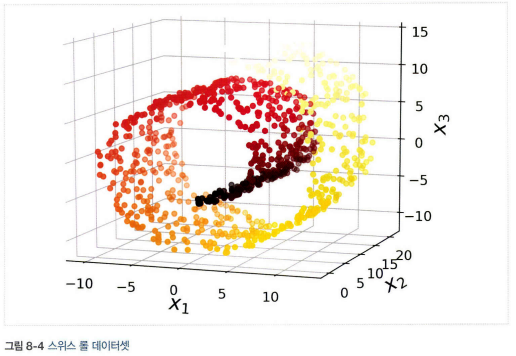

스위스롤 데이터셋을 그냥 평면에 투영시키면 왼쪽 그림처럼 데이터의 층이 서로 뭉개진다.<br> 우리가 원하는 2D 데이터셋은 오른쪽 그림처럼 스위스롤을 펼쳐서 만든 데이터셋이다.

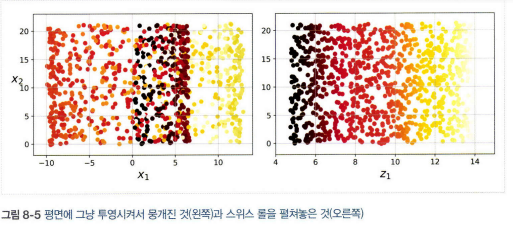

## 8.2.2 매니폴드 학습

* 매니폴드
<br> : $d$ 차원 매니폴드는 국부적으로 $d$ 차원 초평면으로 보일 수 있는 $n$ 차원 공간의 일부이다 $(d<n)$
<br> (예) 스위스롤은 2D 매니폴드
> 매니폴드 학습(manifold learning) : 매니폴드를 모델링 하는 것
<br> ※ 이는 대부분 실제 고차원 데이터셋이 더 낮은 저차원 매니폴드에 가깝게 놓여 있다는 매니폴드 가정/가설에 근거한다.

매니폴드 가정은 처리해야할 작업이 저차원의 매니폴드 공간에 표현되면 더 간단해질 것이란 가정과 병행되기도 하는데,
<br> 이런 가정이 항상 유효하지는 않다. 아래의 그림을 보자.

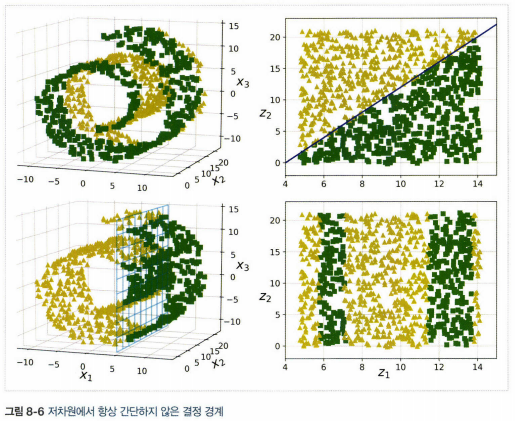

첫번째 행에서는 매니폴드의 결정경계가 단순한 직선이지만, 두번째 행의 매니폴드의 결정경계를 보면 복잡하다는 것을 알 수가 있다.<br>
이처럼 매니폴드로 표현하는것이 항상 좋은 결과를 내는 것은 아니다.

#8.3 PCA

주성분 분석(principal component analysis, PCA)
<br> : 데이터에 가장 가까운 초평면(hyperplane)을 정의한 다음, 데이터를 이 평면에 투영시킨다.

##8.3.1 분산 보존

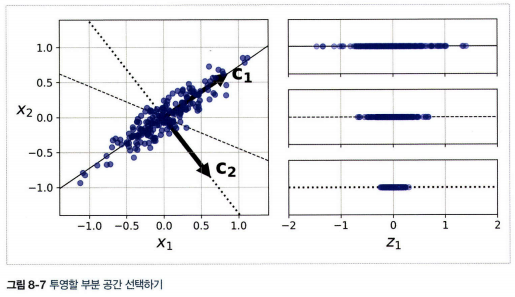

위의 그림을 보면, 실선의 경우에는 분산을 최대로 보존하는 반면, 점선에 투영된 것은 분산을 매우 적게 유지하는 것을 볼 수 있다.
<br> 우리는 **분산이 최대로 보존되는 축을 선택하는 것이 정보가 가장 적게 손실**되기 때문에 합리적이라고 할 수 있다.

> Q. 분산이 최대로 보존되는 축은 어떻게 선택하는가?
<br> A. 원본 데이터셋과 투영된 것 사이의 평균 제곱 거리를 최소화하는 축을 찾는다.

##8.3.2 주성분

주성분 분석(PCA)는 훈련 세트에서 분산이 최대인 축을 찾는다.
<br> 첫번째 축에 직교하고 남은 분산을 최대한 보존하는 두번째 축을 찾게 되며, 고차원일수록 이를 반복하여 축들을 찾게 된다.
> 주성분(principal component, PC) : $i$번째 축을 이 데이터의 $i$번째 주성분이라 한다.

> Q. 훈련 세트의 주성분은 어떻게 찾는가?
<br> A. 특잇값 분해(singular value decomposition, SVD)라는 표준 행렬 분해 기술을 사용해서 <br> 훈련 세트 행렬 $X$를 세 개 행렬의 행렬 곱셈 $X = U \sum V^T$으로 분해 ($V$가 주성분 행렬)

In [ ]:
# 3D 데이터셋 만들기
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [ ]:
# 넘파이의 svd() 함수를 사용해 훈련 세트의 처음 두개의 주성분을 구해보자
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [ ]:
m, n = X.shape

S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

In [ ]:
np.allclose(X_centered, U.dot(S).dot(Vt))

True

##8.3.3 d차원으로 투영하기

주성분을 모두 구한 후, 처음 d개의 주성분으로 정의한 초평면에 투영하여 데이터셋의 차원을 d차원 축소시킬 수 있다.
<br> 이 초평면은 분산을 가능한 한 최대로 보존하는 투영임을 보장한다.

초평면에 훈련 세트를 투영하고, $d$ 차원으로 축소된 데이터셋을 얻는다.

* 훈련 세트를 d차원으로 투영하기<br>
$X_{d-proj} = X W_d$

$\begin{cases}
X_{d-proj} : d차원으로 축소된 데이터셋\\
X : 행렬 = (샘플수, 차원)\\
W_d : 주성분의 첫 d열로 구성된 행렬\\
\end{cases}$

In [ ]:
# 첫 두개의 주성분으로 정의된 평면에 훈련 세트를 투영
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

In [ ]:
X2D_using_svd = X2D

이제 PCA 변환이 되었다!

##8.3.4 사이킷런 사용하기

사이킷런에서는 PCA가 아주 간단하다. 데이터셋에서 평균을 빼는 작업도 대신 처리해준다.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

In [ ]:
X2D[:5]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

In [ ]:
X2D_using_svd[:5]

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

데이터셋을 조금 다르게해서 PCA를 실행하면 결과가 달라질 것이다. 일반적으로 달라지는 것은 일부 축이 반대로 바뀌는 정도이다. 이 예에서 사이킷런의 PCA는 두 축이 반대로 뒤집힌 것외에는 SVD 방식을 사용한 것과 통일한 투영 결과를 만든다.

In [ ]:
np.allclose(X2D, -X2D_using_svd)

True

평면(PCA 2D 부분공간)에 투영된 3D 포인트를 복원한다.

In [ ]:
X3D_inv = pca.inverse_transform(X2D)